In [1]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
np.random.seed(42)

In [2]:
df = pd.read_csv('bin_locations.csv')
distances = pd.read_csv('distance.csv')

# Adding Fill ratio and distance from depot to Bin location data frame
fill_ratio = [0] + [np.random.rand() for i in range(1, df.shape[0])]
dist_from_0 = distances.iloc[0,:].to_list()
df['distance_from_0(in m)'] = dist_from_0
df['fill_ratio'] = fill_ratio

# Adding Fill per meter column
B_to_T = 10 # Fill ratio in Bin to Fill ratio in Truck
B_to_B = 20 # Fill ratio to amount of Garbage
fill_p_m = [0] + list(B_to_B*df.iloc[1:,5]/df.iloc[1:,4])

df['fill_p_m'] = fill_p_m
df.head()

,Node,x,y,ward,distance_from_0(in m),fill_ratio,fill_p_m
0,Node 0,76.805980,30.683018,-1,0.000000,0.000000,0.000000
1,Node 1,76.702140,30.667839,1,0.121166,0.374540,61.822814
2,Node 2,76.796025,30.717258,2,0.049358,0.950714,385.230322
3,Node 3,76.760852,30.696397,2,0.056260,0.731994,260.219641
4,Node 4,76.725736,30.665169,1,0.108600,0.598658,110.249996


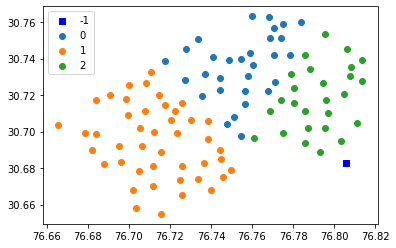

In [3]:
#Getting unique labels
 
u_labels = np.unique(df.ward.to_list())
 
#plotting the results:
for i in u_labels:
  if i == -1:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i, c = 'b', marker = 's')
  else:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i)
plt.legend()
plt.show()

#### Static Optimization function

In [5]:
def opt(df, w1 = 0.2, w2 = 0.8):
  df1 = df[df.ward == 0].sort_values(by = ['fill_p_m'], ascending = False) 
  df2 = df[df.ward == 1].sort_values(by = ['fill_p_m'], ascending = False) 
  df3 = df[df.ward == 2].sort_values(by = ['fill_p_m'], ascending = False)
  fill_ratio = df.fill_ratio
  mdl = Model('CVRP')
  N = []
  for i in df1.index.to_list():
    if sum(df1.loc[N, 'fill_ratio']*B_to_T) + df1.loc[i, 'fill_ratio']*B_to_T <= 100:
      N.append(i)

  N1 = []
  for i in df2.index.to_list():
      if sum(df2.loc[N1, 'fill_ratio']*B_to_T) + df2.loc[i, 'fill_ratio']*B_to_T <= 100:
          N1.append(i)
  
  N2 = []
  for i in df3.index.to_list():
      if sum(df3.loc[N2, 'fill_ratio']*B_to_T) + df3.loc[i, 'fill_ratio']*B_to_T <= 100:
          N2.append(i)

  V = [0] + N                                                                                   # All the vertices
  V1 = [0] + N1                                                                                   # All the vertices
  V2 = [0] + N2                                                                                   # All the vertices
  A = [(i, j) for i in V for j in V if i != j]                                                  # Arcs
  A1 = [(i, j) for i in V1 for j in V1 if i != j]                                                  # Arcs
  A2 = [(i, j) for i in V2 for j in V2 if i != j]                                                  # Arcs
  c = {(i,j) : distances.iloc[i,j] for i,j in A}                                                # cost
  c1 = {(i,j) : distances.iloc[i,j] for i,j in A1}                                                # cost
  c2 = {(i,j) : distances.iloc[i,j] for i,j in A2}                                                # cost

  # Starting Gurobi Model

  x = mdl.addVars(A, vtype = GRB.BINARY)                                                        # X(ij)
  x1 = mdl.addVars(A1, vtype = GRB.BINARY)                                                        # X(ij)
  x2 = mdl.addVars(A2, vtype = GRB.BINARY)                                                        # X(ij)
  y = mdl.addVars(V, vtype = GRB.BINARY)                                                        # Y(i)
  y1 = mdl.addVars(V1, vtype = GRB.BINARY)                                                        # Y(i)
  y2 = mdl.addVars(V2, vtype = GRB.BINARY)                                                        # Y(i)
  u = mdl.addVars(N, vtype = GRB.CONTINUOUS)                                                    # u(i)
  u1 = mdl.addVars(N1, vtype = GRB.CONTINUOUS)                                                    # u(i)
  u2 = mdl.addVars(N2, vtype = GRB.CONTINUOUS)                                                    # u(i)
  mdl.modelSense = GRB.MINIMIZE                                                                 # Minimization model


  mdl.setObjective(quicksum(w1*x[i,j]*c[i,j] - w2*y[i]*fill_ratio.loc[i]*B_to_T for i,j in A) + quicksum(w1*x1[i,j]*c1[i,j] - w2*y1[i]*fill_ratio.loc[i]*B_to_T for i,j in A1) + quicksum(w1*x2[i,j]*c2[i,j] - w2*y2[i]*fill_ratio.loc[i]*B_to_T for i,j in A2))


  # Constraints

  #start at 0
  mdl.addConstr( quicksum(x[0,j] for j in N) == 1 )
  mdl.addConstr( quicksum(x1[0,j] for j in N1) == 1 )
  mdl.addConstr( quicksum(x2[0,j] for j in N2) == 1 )

  #End at 0
  mdl.addConstr( quicksum(x[j,0] for j in N) == 1 )
  mdl.addConstr( quicksum(x1[j,0] for j in N1) == 1 )
  mdl.addConstr( quicksum(x2[j,0] for j in N2) == 1 )

  # Updation of route
  mdl.addConstrs(quicksum(x[i,j] for j in V if j != i) == 1 for i in N)                       
  mdl.addConstrs(quicksum(x1[i,j] for j in V1 if j != i) == 1 for i in N1)                    
  mdl.addConstrs(quicksum(x2[i,j] for j in V2 if j != i) == 1 for i in N2)                    
  
  mdl.addConstrs(quicksum(x[i,j] for i in V if i != j) == 1 for j in N)                       
  mdl.addConstrs(quicksum(x1[i,j] for i in V1 if i != j) == 1 for j in N1)                    
  mdl.addConstrs(quicksum(x2[i,j] for i in V2 if i != j) == 1 for j in N2)                    
  
  # Capacity constraint
  mdl.addConstr(quicksum(y[i]*fill_ratio.loc[i]*B_to_T for i in N) <= 100)                          
  mdl.addConstr(quicksum(y1[i]*fill_ratio.loc[i]*B_to_T for i in N1) <= 100)                       
  mdl.addConstr(quicksum(y2[i]*fill_ratio.loc[i]*B_to_T for i in N2) <= 100)                       
 
  # Tracking fill ratio
  mdl.addConstrs((x[i,j] == 1) >> (u[i] + fill_ratio.loc[i]*B_to_T == u[j])
                  for i,j in A if i != 0 and j!= 0)                                            
  
  mdl.addConstrs((x1[i,j] == 1) >> (u1[i] + fill_ratio.loc[i]*B_to_T == u1[j])
                  for i,j in A1 if i != 0 and j!= 0)                                           
  
  mdl.addConstrs((x2[i,j] == 1) >> (u2[i] + fill_ratio.loc[i]*B_to_T == u2[j])
                  for i,j in A2 if i != 0 and j!= 0)                                           
  
  
  mdl.addConstrs(u[i] >= fill_ratio.loc[i]*B_to_T for i in N)                                  
  mdl.addConstrs(u1[i] >= fill_ratio.loc[i]*B_to_T for i in N1)                                
  mdl.addConstrs(u2[i] >= fill_ratio.loc[i]*B_to_T for i in N2)                                
  
  
  mdl.addConstrs(u[i] <= 100 for i in N)                                                   
  mdl.addConstrs(u1[i] <= 100 for i in N1)                                                 
  mdl.addConstrs(u2[i] <= 100 for i in N2)                                                 
  
  # Time constraint to make model feasible to use
  mdl.Params.MIGap = 0.1                                                                        # Stop at < 10% gap
  mdl.Params.TimeLimit = 900                                                                    # Stop after 900s (15 minutes)
  
  # Optimize the model

  mdl.optimize()
  active_arcs = [a for a in A if x[a].x > 0.99]                                                 # Store the arcs in the list active_arcs
  active_arcs1 = [a for a in A1 if x1[a].x > 0.99]                                              # Store the arcs in the list active_arcs
  active_arcs2 = [a for a in A2 if x2[a].x > 0.99]                                              # Store the arcs in the list active_arcs
  return [active_arcs, active_arcs1, active_arcs2]                                              # Return those arcs 

In [6]:
active_arc = opt(df)

Restricted license - for non-production use only - expires 2023-10-25
No parameters matching 'MIGap' found
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 177 rows, 723 columns and 1398 nonzeros
Model fingerprint: 0x2503d1a4
Model has 552 general constraints
Variable types: 42 continuous, 681 integer (681 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [1e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+02]
  GenCon rhs range [5e-01, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1125 rows and 147 columns
Presolve time: 0.68s
Presolved: 1302 rows, 870 columns, 8379 nonzeros
Variable types: 234 continuous, 636 integer (636 binary)

Root relaxation: objective -3.350851e+03, 213 iterations, 0.04 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Boun

In [7]:
df.to_csv('Static Data/Truck Data.csv')
#Save Data Truck 1
nodes1 = [0]
fill1 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[0] if x == nodes1[-1] )
    nodes1.append(next_element)
    if next_element == 0:
        fill1.append(np.sum(fill1))
    else:
        fill1.append(df.loc[next_element, 'fill_ratio'])
visit_static_1 = pd.DataFrame({'Nodes' : nodes1, 'Fill Ratio' : fill1})
file_name = 'Static Data/Visited Truck Data/Visited Truck 1.csv'
visit_static_1.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

#Save Data Truck 2
nodes2 = [0]
fill2 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[1] if x == nodes2[-1] )
    nodes2.append(next_element)
    if next_element == 0:
        fill2.append(np.sum(fill2))
    else:
        fill2.append(df.loc[next_element, 'fill_ratio'])
visit_static_2 = pd.DataFrame({'Nodes' : nodes2, 'Fill Ratio' : fill2})
file_name = 'Static Data/Visited Truck Data/Visited Truck 2.csv'
visit_static_2.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

#Save Data Truck 3
nodes3 = [0]
fill3 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[2] if x == nodes3[-1] )
    nodes3.append(next_element)
    if next_element == 0:
        fill3.append(np.sum(fill3))
    else:
        fill3.append(df.iloc[next_element, 5])
visit_static_3 = pd.DataFrame({'Nodes' : nodes3, 'Fill Ratio' : fill3})
file_name = 'Static Data/Visited Truck Data/Visited Truck 3.csv'
visit_static_3.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

In [8]:
print(f"Fill of truck 1 : {round(visit_static_1.iloc[-1, 1]*10, 4)}%")
print(f"Fill of truck 2 : {round(visit_static_2.iloc[-1, 1]*10, 4)}%")
print(f"Fill of truck 3 : {round(visit_static_3.iloc[-1, 1]*10, 4)}%")

print("\n")
print(f"Garbage fill of truck 1 : {round(visit_static_1.iloc[-1, 1]*B_to_B, 4)}")
print(f"Garbage fill of truck 2 : {round(visit_static_2.iloc[-1, 1]*B_to_B, 4)}")
print(f"Garbage fill of truck 3 : {round(visit_static_3.iloc[-1, 1]*B_to_B, 4)}")

dist1 = 0
stat_dist = [0,0,0]
j = 0
for i in active_arc:
    for k in i:
        stat_dist[j] = stat_dist[j] + distances.iloc[k[0], k[1]]
    j = j + 1

print("\n")
print(f"Distance travelled by truck 1 : {round(stat_dist[0], 4)}")
print(f"Distance travelled by truck 2 : {round(stat_dist[1], 4)}")
print(f"Distance travelled by truck 3 : {round(stat_dist[2], 4)}")    
    
print("\n")
print(f"Garbage per meter by truck 1 : {round(visit_static_1.iloc[-1, 1]*B_to_T / stat_dist[0], 4)}")
print(f"Garbage per meter by truck 2 : {round(visit_static_2.iloc[-1, 1]*B_to_T / stat_dist[1], 4)}")
print(f"Garbage per meter by truck 3 : {round(visit_static_3.iloc[-1, 1]*B_to_T / stat_dist[2], 4)}")

Fill of truck 1 : 99.9536%
Fill of truck 2 : 99.8997%
Fill of truck 3 : 99.2973%


Garbage fill of truck 1 : 199.9073
Garbage fill of truck 2 : 199.7993
Garbage fill of truck 3 : 198.5946


Distance travelled by truck 1 : 0.4569
Distance travelled by truck 2 : 0.4574
Distance travelled by truck 3 : 0.279


Garbage per meter by truck 1 : 218.7861
Garbage per meter by truck 2 : 218.3917
Garbage per meter by truck 3 : 355.8875


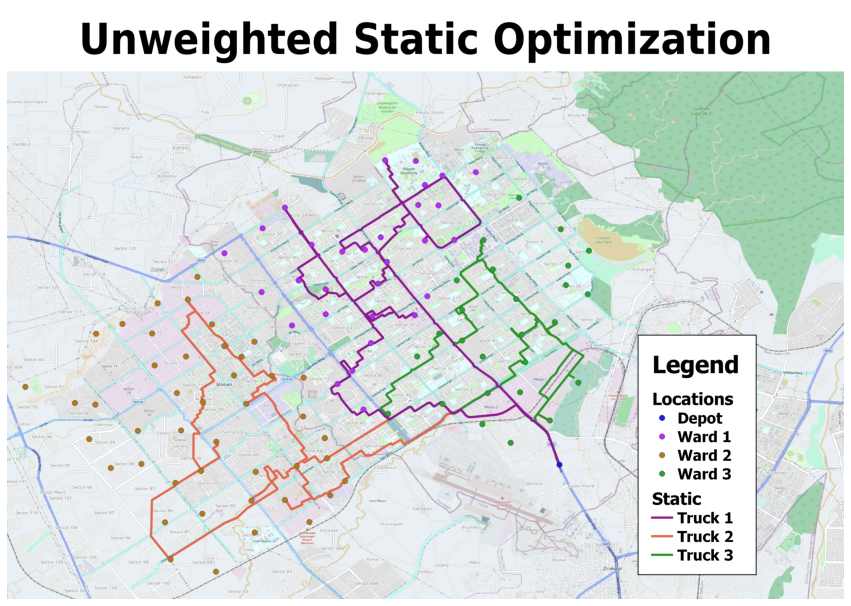

In [9]:
Figure = plt.figure(figsize=(15, 15))
image = cv2.imread('images/Static_unweighted.png')
plt.imshow(image)
plt.axis(False)
plt.show()

#### Dynamic optimization function

In [9]:
def dyn_opt(df1, df2, df3, visit1, visit2, visit3, w1 = 0.5, w2 = 0.5, m = 0, n1_done = 0, n2_done = 0, n3_done = 0, obj_value = []):
    
    # Model
    mdl = Model('CVRP')

    visit1.Node = visit1.Node.astype('int')
    visit2.Node = visit2.Node.astype('int')
    visit3.Node = visit3.Node.astype('int')
    

    # Initalization
    obj1, obj2, obj3 = 0, 0, 0 
    f_prev = 'fill_ratio_' + str(m-1)
    fpm = 'fill_per_m_' + str(m)
    f_new = 'fill_ratio_' + str(m)
    start_node = [
        visit1.iloc[-1,0],
        visit2.iloc[-1,0],
        visit3.iloc[-1,0]
        ]
    print(f'\nStart nodes : {start_node}\nFill Ratios : {sum(visit1.iloc[:,1])} | {sum(visit2.iloc[:,1])} | {sum(visit3.iloc[:,1])}')
    # df1 = df[df.ward == 0]
    # df2 = df[df.ward == 1]
    # df3 = df[df.ward == 2]
    if n1_done != 1:
        if m == 0:
            fill1 = df1.fill_ratio
        else:
            fill1 = df1.loc[:, f_prev]
        df1.insert(df1.shape[1], f_new, fill1)
        if m != 0:
            for i in df1.index.tolist():
                if i not in visit1.Node.to_list() and np.random.rand() < 0.80:
                    df1.loc[i, f_new] = df1.loc[i, f_new] + np.random.uniform(0, 1 - df1.loc[i, f_new])/10
        dist = distances.iloc[start_node[0], df1.index.to_list()].tolist()
        # print(dist)
        # dist = [i*1000/dis_conv for i in dist]
        # dist = [i for i in dist]
        # print(dist)
        dist_name = 'distance_from_' + str(start_node[0])
        if dist_name in df1.columns:
            dist_name = dist_name + '_' + str(np.random.rand())
        df1.insert(df1.shape[1], dist_name, dist)
        # df1.insert(df1.shape[1], fpm, B_to_B*df1.loc[:,f_new]/df1.loc[:,dist_name])
        df1.insert(df1.shape[1], fpm, df1.loc[:,f_new]/df1.loc[:,dist_name])

        df1 = df1.sort_values(by = f_new, ascending = False)
        fill_1 = pd.DataFrame({'fill' : df1.loc[:, f_new].to_list() + [0]}, index = df1.index.tolist() + [0])
        N1 = []
        for i in df1.index.tolist():
            if i not in visit1.Node.to_list() and (df1.loc[i, f_new] + sum(df1.loc[N1, f_new]))*B_to_T <= 100 - sum(visit1.iloc[:,1])*B_to_T:
                N1.append(i)
        if m == 0:
            V1 = N1 + [0]
        else:
            V1 = [start_node[0]] + N1 + [0]
        print(f'\nV1:{V1}\n')
        A1 = [(i,j) for i in V1 for j in V1 if i != j]
        c1 = {(i,j) : distances.iloc[i, j] for i,j in A1}
        # c1 = {(i,j) : distances.iloc[i, j]/dis_conv for i,j in A1}
        x1 = mdl.addVars(A1, vtype = GRB.BINARY)
        y1 = mdl.addVars(V1, vtype = GRB.BINARY)
        u1 = mdl.addVars(N1, vtype = GRB.CONTINUOUS)
        obj1 = quicksum( (w1*x1[i, j]*c1[(i, j)]) - w2*y1[i]*fill_1.loc[i, 'fill']*B_to_T for i,j in A1)


    if n2_done != 1:
        if m == 0:
            fill2 = df2.fill_ratio
        else:
            fill2 = df2.loc[:, f_prev]
        df2.insert(df2.shape[1], f_new, fill2)
        if m != 0:
            for i in df2.index.tolist():
                if i not in visit2.Node.to_list() and np.random.rand() < 0.80:
                    df2.loc[i, f_new] = df2.loc[i, f_new] + np.random.uniform(0, 1 - df2.loc[i, f_new])/10
        dist = distances.iloc[start_node[1], df2.index.to_list()].tolist()
        # dist = [i*1000/dis_conv for i in dist]
        # dist = [i for i in dist]
        dist_name = 'distance_from_' + str(start_node[1])
        if dist_name in df2.columns:
            dist_name = dist_name + '_' + str(np.random.rand())
        df2.insert(df2.shape[1], dist_name, dist)
        # df2.insert(df2.shape[1], fpm, B_to_B*df2.loc[:,f_new]/df2.loc[:,dist_name])
        df2.insert(df2.shape[1], fpm, df2.loc[:,f_new]/df2.loc[:,dist_name])

        df2 = df2.sort_values(by = f_new, ascending = False)
        fill_2 = pd.DataFrame({'fill' : df2.loc[:, f_new].to_list() + [0]}, index = df2.index.tolist() + [0])
        N2 = []
        for i in df2.index.tolist():
            if i not in visit2.Node.to_list() and (df2.loc[i, f_new] + sum(df2.loc[N2, f_new]))*B_to_T <= 100 - sum(visit2.iloc[:,1])*B_to_T:
                N2.append(i)
        if m == 0:
            V2 = N2 + [0]
        else:
            V2 = [start_node[1]] + N2 + [0]
        # print(f'\nV2:{V2}\n')
        A2 = [(i,j) for i in V2 for j in V2 if i != j]
        c2 = {(i,j) : distances.iloc[i, j] for i,j in A2}
        # c2 = {(i,j) : distances.iloc[i, j]/dis_conv for i,j in A2}
        x2 = mdl.addVars(A2, vtype = GRB.BINARY)
        y2 = mdl.addVars(V2, vtype = GRB.BINARY)
        u2 = mdl.addVars(N2, vtype = GRB.CONTINUOUS)
        obj2 = quicksum( (w1*x2[i, j]*c2[(i, j)]) - w2*y2[i]*fill_2.loc[i, 'fill']*B_to_T for i,j in A2)
        
    if n3_done != 1:
        if m == 0:
            fill3 = df3.fill_ratio
        else:
            fill3 = df3.loc[:, f_prev]
        df3.insert(df3.shape[1], f_new, fill3)
        if m != 0:
            for i in df3.index.tolist():
                if i not in visit3.Node.to_list() and np.random.rand() < 0.80:
                    df3.loc[i, f_new] = df3.loc[i, f_new] + np.random.uniform(0, 1 - df3.loc[i, f_new])/10
        dist = distances.iloc[start_node[2], df3.index.to_list()].tolist()
        # dist = [i for i in dist]
        # dist = [i*1000/dis_conv for i in dist]
        dist_name = 'distance_from_' + str(start_node[2])
        if dist_name in df3.columns:
            dist_name = dist_name + '_' + str(np.random.rand())
        df3.insert(df3.shape[1], dist_name, dist)
        df3.insert(df3.shape[1], fpm, df3.loc[:,f_new]/df3.loc[:,dist_name])
        df3 = df3.sort_values(by = f_new, ascending = False)
        fill_3 = pd.DataFrame({'fill' : df3.loc[:, f_new].to_list() + [0]}, index = df3.index.tolist() + [0])
        N3 = []
        for i in df3.index.tolist():
            if i not in visit3.Node.to_list() and (df3.loc[i, f_new] + sum(df3.loc[N3, f_new]))*B_to_T <= 100 - sum(visit3.iloc[:,1])*B_to_T:
                N3.append(i)
        if m == 0:
            V3 = N3 + [0]
        else:
            V3 = [start_node[2]] + N3 + [0]
        # print(f'\nV3:{V3}\n')
        A3 = [(i,j) for i in V3 for j in V3 if i != j]
        c3 = {(i,j) : distances.iloc[i, j] for i,j in A3}
        # c3 = {(i,j) : distances.iloc[i, j]/dis_conv for i,j in A3}
        x3 = mdl.addVars(A3, vtype = GRB.BINARY)
        y3 = mdl.addVars(V3, vtype = GRB.BINARY)
        u3 = mdl.addVars(N3, vtype = GRB.CONTINUOUS)
        obj3 = quicksum( (w1*x3[i, j]*c3[(i, j)]) - w2*y3[i]*fill_3.loc[i, 'fill']*B_to_T for i,j in A3)
   
    # Model
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(obj1 + obj2 + obj3)

    # Constraints
    if n1_done == 0:
        mdl.addConstrs( quicksum( x1[i,j] for j in V1 if j != i) == 1 for i in N1 )
        mdl.addConstrs( quicksum( x1[i,j] for i in V1 if i != j) == 1 for j in N1 )
        mdl.addConstr( quicksum( y1[i]*fill_1.loc[i, 'fill']*B_to_T for i in N1 ) <= (100 - sum(visit1.iloc[:, 1])*B_to_T) )
        mdl.addConstr( quicksum( x1[start_node[0], j] for j in N1) == 1)
        if start_node[0] != 0:
            mdl.addConstr( quicksum( x1[j, start_node[0]] for j in N1) == 0)
        mdl.addConstr( quicksum( x1[j, 0] for j in N1) == 1)
        if start_node[0] != 0:
            mdl.addConstr( quicksum( x1[0, j] for j in N1) == 0)
        mdl.addConstrs(
        (x1[i,j] == 1) >> (u1[i] + fill_1.loc[i, 'fill']*B_to_T == u1[j]) for i,j in A1 if i != 0 and j != 0 and i != int(visit1.iloc[-1,0]) and j != int(visit1.iloc[-1,0]) 
        )
        mdl.addConstrs( u1[i] >= fill_1.loc[i, 'fill']*B_to_T for i in N1 )
        mdl.addConstrs( u1[i] <= 100 - sum(visit1.iloc[:, 1])*B_to_T for i in N1 )
    
    if n2_done == 0:
        mdl.addConstrs( quicksum( x2[i,j] for j in V2 if j != i) == 1 for i in N2 )
        mdl.addConstrs( quicksum( x2[i,j] for i in V2 if i != j) == 1 for j in N2 )
        mdl.addConstr( quicksum( y2[i]*fill_2.loc[i, 'fill']*B_to_T for i in N2 ) <= (100 - sum(visit2.iloc[:, 1])*B_to_T) )
        mdl.addConstr( quicksum( x2[start_node[1], j] for j in N2) == 1)
        if start_node[1] != 0:
            mdl.addConstr( quicksum( x2[j, start_node[1]] for j in N2) == 0)
        mdl.addConstr( quicksum( x2[j, 0] for j in N2) == 1)
        if start_node[1] != 0:
            mdl.addConstr( quicksum( x2[0, j] for j in N2) == 0)
        mdl.addConstrs(
        (x2[i,j] == 1) >> (u2[i] + fill_2.loc[i, 'fill']*B_to_T == u2[j]) for i,j in A2 if i != 0 and j != 0 and i != int(visit2.iloc[-1,0]) and j != int(visit2.iloc[-1,0]) 
        )
        mdl.addConstrs( u2[i] >= fill_2.loc[i, 'fill']*B_to_T for i in N2 )
        mdl.addConstrs( u2[i] <= 100 - sum(visit2.iloc[:, 1])*B_to_T for i in N2 )
    
    if n3_done == 0:
        mdl.addConstrs( quicksum( x3[i,j] for j in V3 if j != i) == 1 for i in N3 )
        mdl.addConstrs( quicksum( x3[i,j] for i in V3 if i != j) == 1 for j in N3 )
        mdl.addConstr( quicksum( y3[i]*fill_3.loc[i, 'fill']*B_to_T for i in N3 ) <= (100 - sum(visit3.iloc[:, 1])*B_to_T) )
        mdl.addConstr( quicksum( x3[start_node[2], j] for j in N3) == 1)
        if start_node[2] != 0:
            mdl.addConstr( quicksum( x3[j, start_node[2]] for j in N3) == 0)
        mdl.addConstr( quicksum( x3[j, 0] for j in N3) == 1)
        if start_node[2] != 0:
            mdl.addConstr( quicksum( x3[0, j] for j in N3) == 0)
        mdl.addConstrs(
        (x3[i,j] == 1) >> (u3[i] + fill_3.loc[i, 'fill']*B_to_T == u3[j]) for i,j in A3 if i != 0 and j != 0 and i != int(visit3.iloc[-1,0]) and j != int(visit3.iloc[-1,0]) 
        )
        mdl.addConstrs( u3[i] >= fill_3.loc[i, 'fill']*B_to_T for i in N3 )
        mdl.addConstrs( u3[i] <= 100 - sum(visit3.iloc[:, 1])*B_to_T for i in N3 )

    # Model time Restrictions

    mdl.Params.MIPGap = 0.1
    mdl.Params.TimeLimit = 900

    # Optimize model
    mdl.optimize()
    q = mdl.getObjective()
    obj_value.append(q.getValue())

    speed = 0.014
    # TODO : Time simulation
    if n1_done == 0:
        active_arcs1 = [a for a in A1 if x1[a].x > 0.99]
        time = 900 # 15 minutes
        visited1 = 0
        next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
        while (time - c1[visit1.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed) >= 0) and next_element != 0:
            time = time - c1[visit1.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed)
            visit1.loc[len(visit1.index)] = [next_element, df1.loc[next_element, f_new]]
            df1.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
            visited1 = visited1 + 1
        if visited1 == 0:
            print('Forecully entered the value 1.')
            visit1.loc[len(visit1.index)] = [next_element, df1.loc[next_element, f_new]]
            df1.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
        if next_element == 0:
            visit1.loc[len(visit1.index)] = [next_element, sum(visit1.iloc[:, 1])]
            print(f'\nOptimization done for ward 1')
            file_name = 'truck1_data/truck1_' + str(w1) + '_' + str(w2) + '.csv'
            df1.to_csv(file_name, index = False)
            file_name = 'visited_truck1/visited_truck1_' + str(w1) + '_' + str(w2) + '.csv'
            visit1.to_csv(file_name, index = False)
            n1_done = 1
        print(f'Active arcs | Truck 1 | Start Node : {start_node[0]} :\n{active_arcs1}')

    if n2_done == 0:
        active_arcs2 = [a for a in A2 if x2[a].x > 0.99]
        time = 900 # 15 minutes
        visited2 = 0
        next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
        while (time - c2[visit2.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed) >= 0) and next_element != 0:
            time = time - c2[visit2.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed)
            visit2.loc[len(visit2.index)] = [next_element, df2.loc[next_element, f_new]]
            df2.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
            visited2 = visited2 + 1
        if visited2 == 0:
            print('Forecully entered the value 2.')
            visit2.loc[len(visit2.index)] = [next_element, df2.loc[next_element, f_new]]
            df2.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
        if next_element == 0:
            visit2.loc[len(visit2.index)] = [next_element, sum(visit2.iloc[:, 1])]
            print(f'\nOptimization done for truck 2')
            file_name = 'truck2_data/truck2_' + str(w1) + '_' + str(w2) + '.csv'
            df2.to_csv(file_name, index = False)
            file_name = 'visited_truck2/visited_truck2_' + str(w1) + '_' + str(w2) + '.csv'
            visit2.to_csv(file_name, index = False)
            n2_done = 1
        print(f'Active arcs | Truck 2 | Start Node : {start_node[1]} :\n{active_arcs2}')

    if n3_done == 0:
        active_arcs3 = [a for a in A3 if x3[a].x > 0.99]
        time = 900 # 15 minutes
        visited3 = 0
        next_element = next( y for x, y in active_arcs3 if x == visit3.iloc[-1, 0] )
        while (time - c3[visit3.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed) >= 0) and next_element != 0:
            time = time - c3[visit3.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed)
            visit3.loc[len(visit3.index)] = [next_element, df3.loc[next_element, f_new]]
            df3.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs3 if x == visit3.iloc[-1, 0] )
            visited3 = visited3 + 1
        if visited3 == 0:
            print('Forecully entered the value 3.')
            visit3.loc[len(visit3.index)] = [next_element, df3.loc[next_element, f_new]]
            df3.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs3 if x == visit3.iloc[-1, 0] )
        if next_element == 0:
            visit3.loc[len(visit3.index)] = [next_element, sum(visit3.iloc[:, 1])]
            print(f'\nOptimization done for truck 3')
            file_name = 'truck3_data/truck3_' + str(w1) + '_' + str(w2) + '.csv'
            df3.to_csv(file_name, index = False)
            file_name = 'visited_truck3/visited_truck3_' + str(w1) + '_' + str(w2) + '.csv'
            visit3.to_csv(file_name, index = False)
            n3_done = 1
        print(f'Active arcs | Truck 3 | Start Node : {start_node[2]} :\n{active_arcs3}')

    print(f'\n{n1_done, n2_done, n3_done}')
    m = m + 1
    # df4 = pd.concat([df1, df2, df3])
    # df4.loc[0, :] = df.loc[0]
    if n1_done == 1 and n2_done == 1 and n3_done == 1:
        print('\nDone computation')
        return obj_value
    dyn_opt(df1 = df1, df2 = df2, df3 = df3, visit1 = visit1, visit2 = visit2, visit3 = visit3, m = m, w1 = w1, w2 = w2, n1_done = n1_done, n2_done = n2_done, n3_done = n3_done, obj_value = obj_value)
    return obj_value

In [10]:
visit1, visit2, visit3 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    )
df1 = df[df.ward == 0]
df2 = df[df.ward == 1]
df3 = df[df.ward == 2]

obj_value = dyn_opt(df1, df2, df3, w1 = 0.5, w2 = 0.5, visit1 = visit1, visit2 = visit2, visit3 = visit3)


Start nodes : [0, 0, 0]
Fill Ratios : 0.0 | 0.0 | 0.0

V1:[89, 13, 36, 26, 95, 92, 10, 88, 82, 21, 55, 94, 66, 28, 79, 43, 73, 0]

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 177 rows, 731 columns and 1414 nonzeros
Model fingerprint: 0x11a56bb9
Model has 560 general constraints
Variable types: 42 continuous, 689 integer (689 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [3e-03, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 1e+02]
  GenCon rhs range [6e-02, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1157 rows and 157 columns
Presolve time: 0.73s
Presolved: 1334 rows, 888 columns, 8545 nonzeros
Variable types: 244 continuous, 644 integer (644 binary)

Root relaxation: objective -2.098532e+03, 192 iterations, 0.02 seconds (0.00 work uni

In [11]:
v1 = pd.read_csv('visited_truck1/visited_truck1_0.5_0.5.csv')
v2 = pd.read_csv('visited_truck2/visited_truck2_0.5_0.5.csv')
v3 = pd.read_csv('visited_truck3/visited_truck3_0.5_0.5.csv')
v1.Node = v1.Node.astype('int')
v2.Node = v2.Node.astype('int')
v3.Node = v3.Node.astype('int')
path1 = []
path2 = []
path3 = []
for i in range(len(v1) - 1):
    path1.append((v1.iloc[i, 0], v1.iloc[i + 1, 0]))
for i in range(len(v2) - 1):
    path2.append((v2.iloc[i, 0], v2.iloc[i + 1, 0]))
for i in range(len(v3) - 1):
    path3.append((v3.iloc[i, 0], v3.iloc[i + 1, 0]))
gar1 = v1.iloc[-1,1]*10
gar2 = v2.iloc[-1,1]*10
gar3 = v3.iloc[-1,1]*10
dist1 = sum([distances.iloc[i,j] for i,j in path1])
dist2 = sum([distances.iloc[i,j] for i,j in path2])
dist3 = sum([distances.iloc[i,j] for i,j in path3])

print("\n")
print(f'Fill Ratio of truck 1 : {round(gar1, 4)}')
print(f'Fill Ratio of truck 2 : {round(gar2, 4)}')
print(f'Fill Ratio of truck 3 : {round(gar3, 4)}')

print("\n")
print(f'Garbage collected by truck 1 : {round(gar1/10 * B_to_B, 4)}')
print(f'Garbage collected by truck 2 : {round(gar2/10 * B_to_B, 4)}')
print(f'Garbage collected by truck 3 : {round(gar3/10 * B_to_B, 4)}')

print("\n")
print(f'Distance travelled by truck 1 : {round(dist1, 4)}')
print(f'Distance travelled by truck 2 : {round(dist2, 4)}')
print(f'Distance travelled by truck 3 : {round(dist3, 4)}')

print("\n")
print(f'Garbage per meter for truck 1 : {round(gar1/dist1, 4)}')
print(f'Garbage per meter for truck 2 : {round(gar2/dist2, 4)}')
print(f'Garbage per meter for truck 3 : {round(gar3/dist3, 4)}')



Fill Ratio of truck 1 : 98.7937
Fill Ratio of truck 2 : 99.9784
Fill Ratio of truck 3 : 99.6414


Garbage collected by truck 1 : 197.5875
Garbage collected by truck 2 : 199.9568
Garbage collected by truck 3 : 199.2828


Distance travelled by truck 1 : 0.6819
Distance travelled by truck 2 : 0.4489
Distance travelled by truck 3 : 0.3317


Garbage per meter for truck 1 : 144.8844
Garbage per meter for truck 2 : 222.7354
Garbage per meter for truck 3 : 300.4129


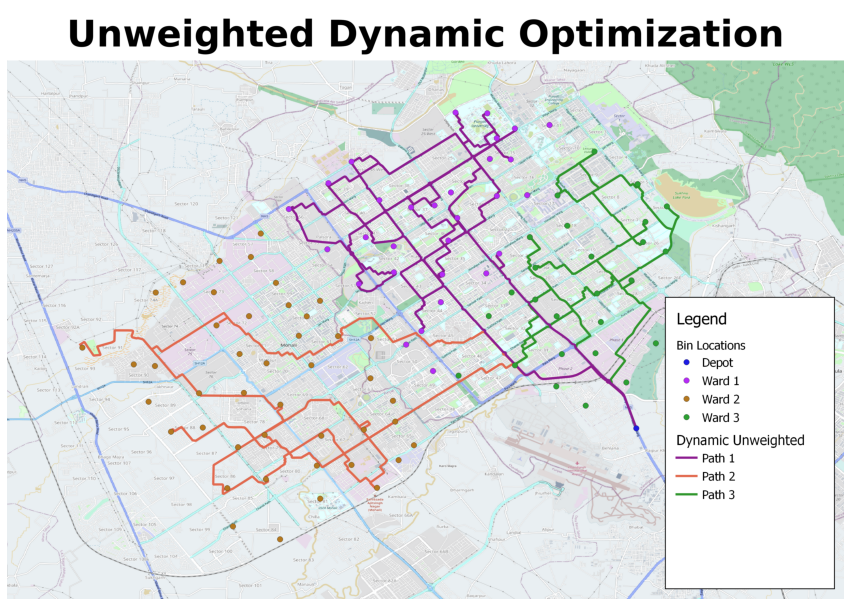

In [13]:
Figure = plt.figure(figsize=(15, 15))
image = cv2.imread('./images/Dynamic Unweighted.png')
plt.imshow(image)
plt.axis(False)
plt.show()

#### Comparison for different W1 and W2

In [12]:
ob = []
for i in range(1, 11, 1):
    w1, w2 = round(i/10, 1), round(1 - i/10, 1)
    visit1, visit2, visit3 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    )

    df1 = df[df.ward == 0]
    df2 = df[df.ward == 1]
    df3 = df[df.ward == 2]

    obj_value = dyn_opt(df1, df2, df3, w1 = w1, w2 = w2, visit1 = visit1, visit2 = visit2, visit3 = visit3)
    ob.append(sum(obj_value))


Start nodes : [0, 0, 0]
Fill Ratios : 0.0 | 0.0 | 0.0

V1:[89, 13, 36, 26, 95, 92, 10, 88, 82, 21, 55, 94, 66, 28, 79, 43, 73, 0]

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 177 rows, 731 columns and 1414 nonzeros
Model fingerprint: 0x82d8f2ca
Model has 560 general constraints
Variable types: 42 continuous, 689 integer (689 binary)
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [6e-04, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 1e+02]
  GenCon rhs range [6e-02, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1157 rows and 157 columns
Presolve time: 1.02s
Presolved: 1334 rows, 888 columns, 8545 nonzeros
Variable types: 244 continuous, 644 integer (644 binary)

Root relaxation: objective -3.778227e+03, 195 iterations, 0.03 seconds (0.00 work uni

In [13]:
print(ob)

[-13931.262772064369, -22900.859198541864, -31664.632150510784, -38276.62506191358, -43622.64542555685, -47751.3217005834, -51200.59064697026, -53059.8852702224, -54138.85960330579, -54135.278589402595]


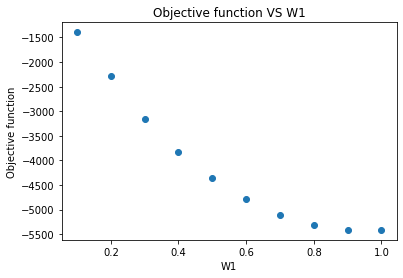

In [14]:
w1 = [i/10 for i in range(1,11,1)]
w2 = [1-i for i in w1]
plt.scatter(w1, [i/len(ob) for i in ob])
plt.title('Objective function VS W1')
plt.xlabel('W1')
plt.ylabel('Objective function')
plt.show()

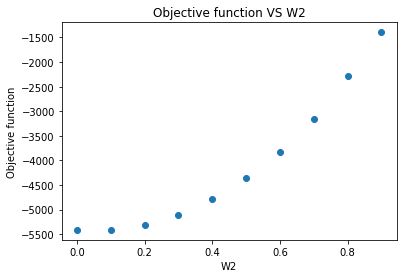

In [15]:
plt.scatter(w2, [i/len(ob) for i in ob])
plt.title('Objective function VS W2')
plt.xlabel('W2')
plt.ylabel('Objective function')
plt.show()

As we can see optimal values for w1 and w2 are 1.0 and 0.0 respectively, i.e. distance is the only important one.

#### Dynamic Best Case Values

In [16]:
v1 = pd.read_csv('visited_truck1/visited_truck1_1.0_0.0.csv')
v2 = pd.read_csv('visited_truck2/visited_truck2_1.0_0.0.csv')
v3 = pd.read_csv('visited_truck3/visited_truck3_1.0_0.0.csv')
v1.Node = v1.Node.astype('int')
v2.Node = v2.Node.astype('int')
v3.Node = v3.Node.astype('int')
path1 = []
path2 = []
path3 = []
for i in range(len(v1) - 1):
    path1.append((v1.iloc[i, 0], v1.iloc[i + 1, 0]))
for i in range(len(v2) - 1):
    path2.append((v2.iloc[i, 0], v2.iloc[i + 1, 0]))
for i in range(len(v3) - 1):
    path3.append((v3.iloc[i, 0], v3.iloc[i + 1, 0]))
gar1 = v1.iloc[-1,1]*10
gar2 = v2.iloc[-1,1]*10
gar3 = v3.iloc[-1,1]*10
dist1 = sum([distances.iloc[i,j] for i,j in path1])
dist2 = sum([distances.iloc[i,j] for i,j in path2])
dist3 = sum([distances.iloc[i,j] for i,j in path3])

print("\n")
print(f'Fill Ratio of truck 1 : {round(gar1, 4)}')
print(f'Fill Ratio of truck 2 : {round(gar2, 4)}')
print(f'Fill Ratio of truck 3 : {round(gar3, 4)}')

print("\n")
print(f'Garbage collected by truck 1 : {round(gar1/10 * B_to_B, 4)}')
print(f'Garbage collected by truck 2 : {round(gar2/10 * B_to_B, 4)}')
print(f'Garbage collected by truck 3 : {round(gar3/10 * B_to_B, 4)}')

print("\n")
print(f'Distance travelled by truck 1 : {round(dist1, 4)}')
print(f'Distance travelled by truck 2 : {round(dist2, 4)}')
print(f'Distance travelled by truck 3 : {round(dist3, 4)}')

print("\n")
print(f'Garbage per meter for truck 1 : {round(gar1/dist1, 4)}')
print(f'Garbage per meter for truck 2 : {round(gar2/dist2, 4)}')
print(f'Garbage per meter for truck 3 : {round(gar3/dist3, 4)}')



Fill Ratio of truck 1 : 99.8744
Fill Ratio of truck 2 : 99.9294
Fill Ratio of truck 3 : 99.37


Garbage collected by truck 1 : 199.7487
Garbage collected by truck 2 : 199.8587
Garbage collected by truck 3 : 198.7401


Distance travelled by truck 1 : 0.5048
Distance travelled by truck 2 : 0.4441
Distance travelled by truck 3 : 0.2984


Garbage per meter for truck 1 : 197.8676
Garbage per meter for truck 2 : 225.0328
Garbage per meter for truck 3 : 333.003


#### Dynamic Worst Case

In [17]:
dt = df.copy()
fill_ratio = [0] + np.ones(df.shape[0]-1).tolist()
dt.fill_ratio = fill_ratio

fill_p_m = [0] + list(B_to_B*dt.iloc[1:,5]/dt.iloc[1:,4])
dt['fill_p_m'] = fill_p_m

# Perform optimization and store the data

visit1, visit2, visit3 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')})
    )

df1 = dt[dt.ward == 0]
df2 = dt[dt.ward == 1]
df3 = dt[dt.ward == 2]
obj_value = dyn_opt(df1, df2, df3, visit1=visit1, visit2=visit2, visit3=visit3, w1=1.0, w2=0.0)


Start nodes : [0, 0, 0]
Fill Ratios : 0.0 | 0.0 | 0.0

V1:[6, 10, 96, 95, 94, 92, 89, 88, 82, 79, 0]

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 129 rows, 393 columns and 750 nonzeros
Model fingerprint: 0x66e3ef34
Model has 270 general constraints
Variable types: 30 continuous, 363 integer (363 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
  GenCon rhs range [1e+01, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 95 rows and 0 columns
Presolve removed 0 rows and 153 columns
Presolve time: 0.36s
Presolved: 224 rows, 240 columns, 1160 nonzeros
Variable types: 20 continuous, 220 integer (220 binary)
Found heuristic solution: objective 1.5482068

Root relaxation: objective 1.070729

In [18]:
v1 = pd.read_csv('visited_truck1/visited_truck1_1.0_0.0.csv')
v2 = pd.read_csv('visited_truck2/visited_truck2_1.0_0.0.csv')
v3 = pd.read_csv('visited_truck3/visited_truck3_1.0_0.0.csv')
v1.Node = v1.Node.astype('int')
v2.Node = v2.Node.astype('int')
v3.Node = v3.Node.astype('int')
path1 = []
path2 = []
path3 = []
for i in range(len(v1) - 1):
    path1.append((v1.iloc[i, 0], v1.iloc[i + 1, 0]))
for i in range(len(v2) - 1):
    path2.append((v2.iloc[i, 0], v2.iloc[i + 1, 0]))
for i in range(len(v3) - 1):
    path3.append((v3.iloc[i, 0], v3.iloc[i + 1, 0]))
gar1 = v1.iloc[-1,1]*10
gar2 = v2.iloc[-1,1]*10
gar3 = v3.iloc[-1,1]*10
dist1 = sum([distances.iloc[i,j] for i,j in path1])
dist2 = sum([distances.iloc[i,j] for i,j in path2])
dist3 = sum([distances.iloc[i,j] for i,j in path3])

print("\n")
print(f'Fill Ratio of truck 1 : {gar1}')
print(f'Fill Ratio of truck 2 : {gar2}')
print(f'Fill Ratio of truck 3 : {gar3}')

print("\n")
print(f'Garbage collected by truck 1 : {gar1/10 * B_to_B}')
print(f'Garbage collected by truck 2 : {gar2/10 * B_to_B}')
print(f'Garbage collected by truck 3 : {gar3/10 * B_to_B}')

print("\n")
print(f'Distance travelled by truck 1 : {dist1}')
print(f'Distance travelled by truck 2 : {dist2}')
print(f'Distance travelled by truck 3 : {dist3}')

print("\n")
print(f'Garbage per meter for truck 1 : {gar1/dist1}')
print(f'Garbage per meter for truck 2 : {gar2/dist2}')
print(f'Garbage per meter for truck 3 : {gar3/dist3}')



Fill Ratio of truck 1 : 100.0
Fill Ratio of truck 2 : 100.0
Fill Ratio of truck 3 : 100.0


Garbage collected by truck 1 : 200.0
Garbage collected by truck 2 : 200.0
Garbage collected by truck 3 : 200.0


Distance travelled by truck 1 : 0.3257089699629545
Distance travelled by truck 2 : 0.4987436144357511
Distance travelled by truck 3 : 0.2740036395277661


Garbage per meter for truck 1 : 307.02255455652266
Garbage per meter for truck 2 : 200.50382021057865
Garbage per meter for truck 3 : 364.9586559227675


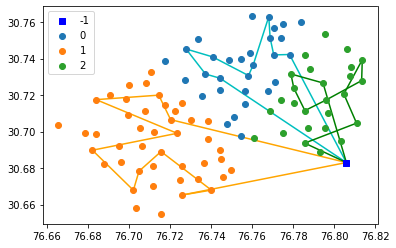

In [19]:
paths = [path1] + [path2] + [path3]
color = ['c','orange','g', 'cyan', 'orangered', 'blueviolet']
for i in u_labels:
  if i == -1:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i, c = 'b', marker = 's')
  else:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i)
for i in range(len(paths)):
  for a in paths[i]:
    plt.plot([df.loc[a[0], 'x'], df.loc[a[1], 'x']],[df.loc[a[0], 'y'], df.loc[a[1], 'y']], zorder=0, c = color[i])
plt.legend()
plt.show()

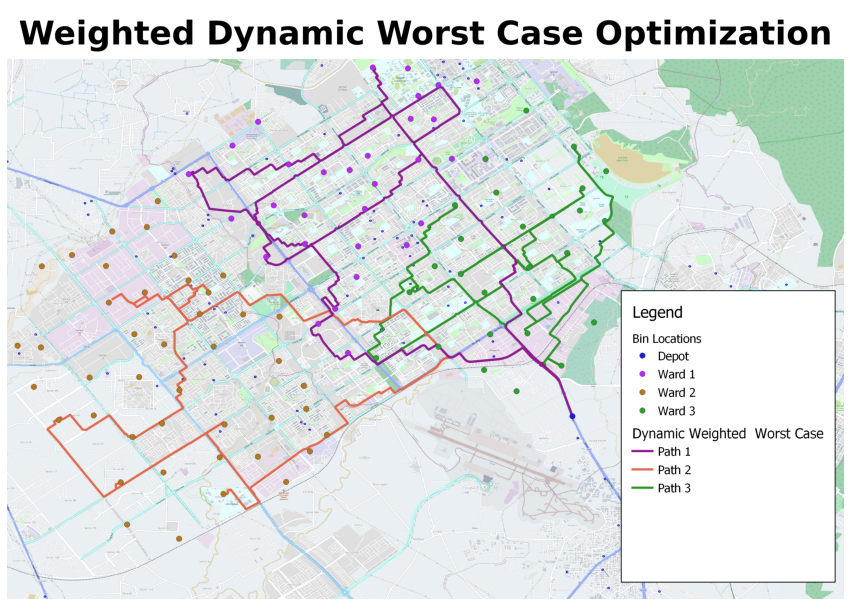

In [22]:
Figure = plt.figure(figsize=(15, 15))
image = cv2.imread('./images/Dynamic Weighted Worst Case.png')
plt.imshow(image)
plt.axis(False)
plt.show()

#### Dynamic multiple trucks

In [20]:
def dyn_multi_opt(df, visit1, visit2, t_name, w1 = 1.0, w2 = 0.0, m = 0, n1_done = 0, n2_done = 0, obj_value = []):
    
    # Model
    mdl = Model('CVRP')

    visit1.Node = visit1.Node.astype('int')
    visit2.Node = visit2.Node.astype('int')
    

    # Initalization
    obj1, obj2 = 0, 0
    f_prev = 'fill_ratio_' + str(m-1)
    fpm = 'fill_per_m_' + str(m)
    f_new = 'fill_ratio_' + str(m)
    start_node = [
        visit1.iloc[-1,0],
        visit2.iloc[-1,0]
        ]
    print(f'\nStart nodes : {start_node}\nFill Ratios : {sum(visit1.iloc[:,1])} | {sum(visit2.iloc[:,1])}')
    if m == 0:
        fill1 = df.fill_ratio
    else:
        fill1 = df.loc[:, f_prev]
    df.insert(df.shape[1], f_new, fill1)
    if m != 0:
        for i in df.index.to_list():
            if i not in visit1.Node.to_list() and i not in visit2.Node.to_list() and np.random.rand() < 0.80:
                df.loc[i, f_new] = df.loc[i, f_new] + np.random.uniform(0, 1 - df.loc[i, f_new])/10
            else:
                df.loc[i, f_new] = df.loc[i, f_new]
    if n1_done != 1:
        # df.insert(df.shape[1], f_new, fill1)
        # if m != 0:
        #     for i in df.index.tolist():
        #         if i not in visit1.Node.to_list() and np.random.rand() < 0.80:
        #             df.loc[i, f_new] = df.loc[i, f_new] + np.random.uniform(0, 1 - df.loc[i, f_new])/10
        dist = distances.iloc[start_node[0], df.index.to_list()].tolist()
        dist_name = 'distance_from_' + str(start_node[0])
        # if dist_name in df.columns:
        #     dist_name = dist_name + '_' + str(np.random.rand())
        fill_1 = pd.DataFrame({'Node' : df.index.tolist() + [0], 'fill' : df.loc[:, f_new].to_list() + [0]})
        df.insert(df.shape[1], dist_name, dist)
        df.insert(df.shape[1], fpm, B_to_B*df.loc[:,f_new]/df.loc[:,dist_name])
        df.sort_values(by = f_new, ascending = False)
        N1 = []
        for i in df.index.tolist():
            if i not in visit1.Node.to_list() and i not in visit2.Node.tolist() and (df.loc[i, f_new] + sum(df.loc[N1, f_new]))*B_to_T <= 100 - sum(visit1.iloc[:,1])*B_to_T:
                N1.append(i)
        if m == 0:
            V1 = N1 + [0]
        else:
            V1 = [start_node[0]] + N1 + [0]
        A1 = [(i,j) for i in V1 for j in V1 if i != j]
        c1 = {(i,j) : distances.iloc[i, j] for i,j in A1}
        x1 = mdl.addVars(A1, vtype = GRB.BINARY)
        y1 = mdl.addVars(V1, vtype = GRB.BINARY)
        u1 = mdl.addVars(N1, vtype = GRB.CONTINUOUS)
        obj1 = quicksum( (w1*x1[i, j]*c1[(i, j)]) - w2*y1[i]*fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i,j in A1)

    if n2_done != 1 and n1_done != 1:
        N2 = []
        for i in df.index.tolist():
            if i not in visit2.Node.to_list() and i not in visit1.Node.tolist() and i not in N1 and (df.loc[i, f_new] + sum(df.loc[N2, f_new]))*B_to_T <= 100 - sum(visit2.iloc[:,1])*B_to_T:
                N2.append(i)
        if m == 0:
            V2 = N2 + [0]
        else:
            V2 = [start_node[1]] + N2 + [0]
        if V2 != []:
            A2 = [(i,j) for i in V2 for j in V2 if i != j]
            c2 = {(i,j) : distances.iloc[i, j] for i,j in A2}
            x2 = mdl.addVars(A2, vtype = GRB.BINARY)
            y2 = mdl.addVars(V2, vtype = GRB.BINARY)
            u2 = mdl.addVars(N2, vtype = GRB.CONTINUOUS)
            obj2 = quicksum( (w1*x2[i, j]*c2[(i, j)]) - w2*y2[i]*fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i,j in A2)
    elif n2_done != 1 and n1_done == 1:
        # df.insert(df.shape[1], f_new, fill1)
        # if m != 0:
        #     for i in df.index.tolist():
        #         if i not in visit1.Node.to_list() and np.random.rand() < 0.80:
        #             df.loc[i, f_new] = df.loc[i, f_new] + np.random.uniform(0, 1 - df.loc[i, f_new])/10
        dist = distances.iloc[start_node[1], df.index.to_list()].tolist()
        dist_name = 'distance_from_' + str(start_node[1])
        if dist_name in df.columns:
            dist_name = dist_name + '_' + str(np.random.rand())
        fill_1 = pd.DataFrame({'Node' : df.index.tolist() + [0], 'fill' : df.loc[:, f_new].to_list() + [0]})
        df.insert(df.shape[1], dist_name, dist)
        df.insert(df.shape[1], fpm, B_to_B*df.loc[:,f_new]/df.loc[:,dist_name])
        df.sort_values(by = f_new, ascending = False)
        N2 = []
        for i in df.index.tolist():
            if i not in visit2.Node.to_list() and i not in visit1.Node.tolist() and i not in N1 and (df.loc[i, f_new] + sum(df.loc[N2, f_new]))*B_to_T <= 100 - sum(visit2.iloc[:,1])*B_to_T:
                N2.append(i)
        if m == 0:
            V2 = N2 + [0]
        else:
            V2 = [start_node[1]] + N2 + [0]
        if V2 != []:
            A2 = [(i,j) for i in V2 for j in V2 if i != j]
            c2 = {(i,j) : distances.iloc[i, j] for i,j in A2}
            x2 = mdl.addVars(A2, vtype = GRB.BINARY)
            y2 = mdl.addVars(V2, vtype = GRB.BINARY)
            u2 = mdl.addVars(N2, vtype = GRB.CONTINUOUS)
            obj2 = quicksum( (w1*x2[i, j]*c2[(i, j)]) - w2*y2[i]*fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i,j in A2)
        
    # Model
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(obj1 + obj2)

    # Constraints
    if n1_done == 0:
        mdl.addConstrs( quicksum( x1[i,j] for j in V1 if j != i) == 1 for i in N1 )
        mdl.addConstrs( quicksum( x1[i,j] for i in V1 if i != j) == 1 for j in N1 )
        mdl.addConstr( quicksum( y1[i]*fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i in N1 ) <= (100 - sum(visit1.iloc[:, 1])*B_to_T) )
        mdl.addConstr( quicksum( x1[start_node[0], j] for j in N1) == 1)
        mdl.addConstr( quicksum( x1[j, 0] for j in N1) == 1)
        if start_node[0] != 0:
            mdl.addConstr( quicksum( x1[0, j] for j in N1) == 0)
        if start_node[0] != 0:
                    mdl.addConstr( quicksum( x1[j, start_node[0]] for j in N1) == 0)
        mdl.addConstrs(
        (x1[i,j] == 1) >> (u1[i] + fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T == u1[j]) for i,j in A1 if i != 0 and j != 0 and i != int(visit1.iloc[-1,0]) and j != int(visit1.iloc[-1,0]) 
        )
        mdl.addConstrs( u1[i] >= fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i in N1 )
        mdl.addConstrs( u1[i] <= 100 - sum(visit1.iloc[:, 1])*B_to_T for i in N1 )
    
    if n2_done == 0:
        mdl.addConstrs( quicksum( x2[i,j] for j in V2 if j != i) == 1 for i in N2 )
        mdl.addConstrs( quicksum( x2[i,j] for i in V2 if i != j) == 1 for j in N2 )
        mdl.addConstr( quicksum( y2[i]*fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i in N2 ) <= (100 - sum(visit2.iloc[:, 1])*B_to_T) )
        mdl.addConstr( quicksum( x2[start_node[1], j] for j in N2) == 1)
        mdl.addConstr( quicksum( x2[j, 0] for j in N2) == 1)
        if start_node[1] != 0:
            mdl.addConstr( quicksum( x2[0, j] for j in N2) == 0)
        if start_node[1] != 0:
                    mdl.addConstr( quicksum( x2[j, start_node[1]] for j in N2) == 0)
        mdl.addConstrs(
        (x2[i,j] == 1) >> (u2[i] + fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T == u2[j]) for i,j in A2 if i != 0 and j != 0 and i != int(visit2.iloc[-1,0]) and j != int(visit2.iloc[-1,0]) 
        )
        mdl.addConstrs( u2[i] >= fill_1[fill_1.Node == i].iloc[0, 1]*B_to_T for i in N2 )
        mdl.addConstrs( u2[i] <= 100 - sum(visit2.iloc[:, 1])*B_to_T for i in N2 )
    
    # Model time Restrictions

    mdl.Params.MIPGap = 0.1
    mdl.Params.TimeLimit = 900

    # Optimize model
    mdl.optimize()
    q = mdl.getObjective()
    obj_value.append(q.getValue())

    speed = 0.014
    # TODO : Time simulation
    if n1_done == 0:
        active_arcs1 = [a for a in A1 if x1[a].x > 0.99]
        time = 900 # 15 minutes
        visited1 = 0
        next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
        while (time - c1[visit1.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed) >= 0) and next_element != 0:
            time = time - c1[visit1.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed)
            visit1.loc[len(visit1)] = [next_element, df.loc[next_element, f_new]]
            df.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
            visited1 = visited1 + 1
        if visited1 == 0:
            print('Forecully entered the value 2.')
            visit1.loc[len(visit1)] = [next_element, df.loc[next_element, f_new]]
            df.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs1 if x == visit1.iloc[-1, 0] )
        if next_element == 0:
            visit1.loc[len(visit1)] = [next_element, sum(visit1.iloc[:, 1])]
            print(f'\nOptimization done for truck 1 - 1')
            file_name = 'visited_' + t_name + '/visited_'+ t_name + '_1_' + str(w1) + '_' + str(w2) + '.csv'
            visit1.to_csv(file_name, index = False)
            n1_done = 1
        print(f'Active arcs | Truck 1 | Start Node : {start_node[0]} :\n{active_arcs1}')

    if n2_done == 0:
        active_arcs2 = [a for a in A2 if x2[a].x > 0.99]
        time = 900 # 15 minutes
        visited2 = 0
        next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
        while (time - c2[visit2.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed) >= 0) and next_element != 0:
            time = time - c2[visit2.iloc[-1, 0], next_element]/(0.00874987636619013529411764705882*speed)
            visit2.loc[len(visit2)] = [next_element, df.loc[next_element, f_new]]
            df.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
            visited2 = visited2 + 1
        if visited2 == 0:
            print('Forecully entered the value 2.')
            visit2.loc[len(visit2.index)] = [next_element, df.loc[next_element, f_new]]
            df.loc[next_element, [f_new, fpm]] = [0.0, 0.0]
            next_element = next( y for x, y in active_arcs2 if x == visit2.iloc[-1, 0] )
        if next_element == 0:
            visit2.loc[len(visit2)] = [next_element, sum(visit2.iloc[:, 1])]
            print(f'\nOptimization done for truck 1 - 2')
            file_name = 'visited_' + t_name + '/visited_'+ t_name + '_2_' + str(w1) + '_' + str(w2) + '.csv'
            visit2.to_csv(file_name, index = False)
            n2_done = 1
        print(f'Active arcs | Truck 2 | Start Node : {start_node[1]} :\n{active_arcs2}')

    print(f'\n{n1_done, n2_done}')
    m = m + 1
    if n1_done == 1 and n2_done == 1:
        print('\nDone computation')
        file_name = t_name + '_data/' + t_name + '_multi_' + str(w1) + '_' + str(w2) + '.csv'
        df.to_csv(file_name, index = False)
        return obj_value
    dyn_multi_opt(df = df, visit1 = visit1, visit2 = visit2, t_name = t_name, m = m, w1 = w1, w2 = w2, n1_done = n1_done, n2_done = n2_done, obj_value = obj_value)
    return obj_value

In [21]:
df1 = df[df.ward == 0]
visit1, visit2 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    )
obj_value1 = dyn_multi_opt(df1, visit1, visit2, t_name = 'truck1')
print('\n\n Truck 1 Done \n\n')
df2 = df[df.ward == 1]
visit1, visit2 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    )
obj_value2 = dyn_multi_opt(df2, visit1, visit2, t_name = 'truck2')
print('\n\n Truck 2 Done \n\n')
df3 = df[df.ward == 2]
visit1, visit2 = (
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    pd.DataFrame({'Node': pd.Series(0, dtype='int'), 'fill_ratio': pd.Series(0, dtype='float')}), 
    )
obj_value3 = dyn_multi_opt(df3, visit1, visit2, t_name = 'truck3')
print('\n\n Truck 3 Done \n\n')


Start nodes : [0, 0]
Fill Ratios : 0.0 | 0.0
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 126 rows, 704 columns and 1374 nonzeros
Model fingerprint: 0xfb446486
Model has 582 general constraints
Variable types: 30 continuous, 674 integer (674 binary)
Coefficient statistics:
  Matrix range     [6e-02, 9e+00]
  Objective range  [7e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 1e+02]
  GenCon rhs range [6e-02, 9e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1104 rows and 102 columns
Presolve time: 0.33s
Presolved: 1230 rows, 806 columns, 8486 nonzeros
Variable types: 206 continuous, 600 integer (600 binary)
Found heuristic solution: objective 1.3290124
Found heuristic solution: objective 1.2290058

Root relaxation: objective 7.007140e-01, 102 iterations, 0.01 seconds (0.00 wor

In [22]:
path11 = []
path12 = []
path21 = []
path22 = []
path31 = []
path32 = []
v11 = pd.read_csv('visited_truck1/visited_truck1_1_1.0_0.0.csv')
v12 = pd.read_csv('visited_truck1/visited_truck1_2_1.0_0.0.csv')
v21 = pd.read_csv('visited_truck2/visited_truck2_1_1.0_0.0.csv')
v22 = pd.read_csv('visited_truck2/visited_truck2_2_1.0_0.0.csv')
v31 = pd.read_csv('visited_truck3/visited_truck3_1_1.0_0.0.csv')
v32 = pd.read_csv('visited_truck3/visited_truck3_2_1.0_0.0.csv')
v11.Node = v11.Node.astype('int')
v12.Node = v12.Node.astype('int')
v21.Node = v21.Node.astype('int')
v22.Node = v22.Node.astype('int')
v31.Node = v31.Node.astype('int')
v32.Node = v32.Node.astype('int')
for i in range(len(v11) - 1):
    path11.append((v11.iloc[i, 0], v11.iloc[i + 1, 0]))
for i in range(len(v12) - 1):
    path12.append((v12.iloc[i, 0], v12.iloc[i + 1, 0]))
for i in range(len(v21) - 1):
    path21.append((v21.iloc[i, 0], v21.iloc[i + 1, 0]))
for i in range(len(v22) - 1):
    path22.append((v22.iloc[i, 0], v22.iloc[i + 1, 0]))
for i in range(len(v31) - 1):
    path31.append((v31.iloc[i, 0], v31.iloc[i + 1, 0]))
for i in range(len(v32) - 1):
    path32.append((v32.iloc[i, 0], v32.iloc[i + 1, 0]))
gar11 = v11.iloc[-1,1]*10
gar12 = v12.iloc[-1,1]*10
gar21 = v21.iloc[-1,1]*10
gar22 = v22.iloc[-1,1]*10
gar31 = v31.iloc[-1,1]*10
gar32 = v32.iloc[-1,1]*10
dist11 = sum([distances.iloc[i,j] for i,j in path11])
dist12 = sum([distances.iloc[i,j] for i,j in path12])
dist21 = sum([distances.iloc[i,j] for i,j in path21])
dist22 = sum([distances.iloc[i,j] for i,j in path22])
dist31 = sum([distances.iloc[i,j] for i,j in path31])
dist32 = sum([distances.iloc[i,j] for i,j in path32])

print("\n")
print(f'Garbage fill for truck 1 - 1 : {round(gar11, 4)}%')
print(f'Garbage fill for truck 1 - 2 : {round(gar12, 4)}%')
print(f'Garbage fill for truck 2 - 1 : {round(gar21, 4)}%')
print(f'Garbage fill for truck 2 - 2 : {round(gar22, 4)}%')
print(f'Garbage fill for truck 3 - 1 : {round(gar31, 4)}%')
print(f'Garbage fill for truck 3 - 2 : {round(gar32, 4)}%')

print("\n")
print(f'Garbage collected for truck 1 - 1 : {round(gar11/10 * B_to_B, 4)}')
print(f'Garbage collected for truck 1 - 2 : {round(gar12/10 * B_to_B, 4)}')
print(f'Garbage collected for truck 2 - 1 : {round(gar21/10 * B_to_B, 4)}')
print(f'Garbage collected for truck 2 - 2 : {round(gar22/10 * B_to_B, 4)}')
print(f'Garbage collected for truck 3 - 1 : {round(gar31/10 * B_to_B, 4)}')
print(f'Garbage collected for truck 3 - 2 : {round(gar32/10 * B_to_B, 4)}')

print("\n")
print(f'Distance travelled for truck 1 - 1 : {round(dist11, 4)}')
print(f'Distance travelled for truck 1 - 2 : {round(dist12, 4)}')
print(f'Distance travelled for truck 2 - 1 : {round(dist21, 4)}')
print(f'Distance travelled for truck 2 - 2 : {round(dist22, 4)}')
print(f'Distance travelled for truck 3 - 1 : {round(dist31, 4)}')
print(f'Distance travelled for truck 3 - 2 : {round(dist32, 4)}')

print("\n")
print(f'Garbage per meter for truck 1 - 1 : {round(gar11/dist11, 4)}')
print(f'Garbage per meter for truck 1 - 2 : {round(gar12/dist12, 4)}')
print(f'Garbage per meter for truck 2 - 1 : {round(gar21/dist21, 4)}')
print(f'Garbage per meter for truck 2 - 2 : {round(gar22/dist22, 4)}')
print(f'Garbage per meter for truck 3 - 1 : {round(gar31/dist31, 4)}')
print(f'Garbage per meter for truck 3 - 2 : {round(gar32/dist32, 4)}')



Garbage fill for truck 1 - 1 : 99.0398%
Garbage fill for truck 1 - 2 : 45.7081%
Garbage fill for truck 2 - 1 : 99.9018%
Garbage fill for truck 2 - 2 : 99.3233%
Garbage fill for truck 3 - 1 : 99.6131%
Garbage fill for truck 3 - 2 : 53.5953%


Garbage collected for truck 1 - 1 : 198.0795
Garbage collected for truck 1 - 2 : 91.4161
Garbage collected for truck 2 - 1 : 199.8035
Garbage collected for truck 2 - 2 : 198.6466
Garbage collected for truck 3 - 1 : 199.2262
Garbage collected for truck 3 - 2 : 107.1906


Distance travelled for truck 1 - 1 : 0.4384
Distance travelled for truck 1 - 2 : 0.2802
Distance travelled for truck 2 - 1 : 0.6023
Distance travelled for truck 2 - 2 : 0.6013
Distance travelled for truck 3 - 1 : 0.371
Distance travelled for truck 3 - 2 : 0.202


Garbage per meter for truck 1 - 1 : 225.933
Garbage per meter for truck 1 - 2 : 163.1289
Garbage per meter for truck 2 - 1 : 165.8562
Garbage per meter for truck 2 - 2 : 165.1829
Garbage per meter for truck 3 - 1 : 268.50

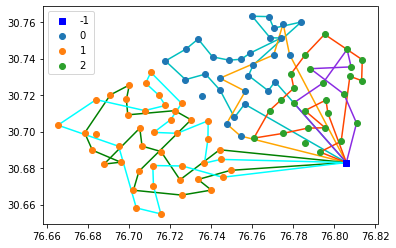

In [26]:
paths = [path11] + [path12] + [path21] + [path22] + [path31] + [path32]
color = ['c','orange','g', 'cyan', 'orangered', 'blueviolet']
for i in u_labels:
  if i == -1:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i, c = 'b', marker = 's')
  else:
    plt.scatter(df[df.ward == i].iloc[:,1] , df[df.ward == i].iloc[:,2] , label = i)
for i in range(len(paths)):
  for a in paths[i]:
    plt.plot([df.loc[a[0], 'x'], df.loc[a[1], 'x']],[df.loc[a[0], 'y'], df.loc[a[1], 'y']], zorder=0, c = color[i])
plt.legend()
plt.show()

#### Static Weighted

In [27]:
active_arc = opt(df, w1=1.0, w2=0.0)

No parameters matching 'MIGap' found
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 177 rows, 723 columns and 1398 nonzeros
Model fingerprint: 0xfa4d8640
Model has 552 general constraints
Variable types: 42 continuous, 681 integer (681 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+01]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+02]
  GenCon rhs range [5e-01, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1125 rows and 147 columns
Presolve time: 0.57s
Presolved: 1302 rows, 870 columns, 8379 nonzeros
Variable types: 234 continuous, 636 integer (636 binary)

Root relaxation: objective 1.023438e+00, 204 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

In [28]:
df.to_csv('Static Data/Weighted Data/Truck Data Weighted.csv')
#Save Data Truck 1
nodes1 = [0]
fill1 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[0] if x == nodes1[-1] )
    nodes1.append(next_element)
    if next_element == 0:
        fill1.append(np.sum(fill1))
    else:
        fill1.append(df.loc[next_element, 'fill_ratio'])
visit_static_1 = pd.DataFrame({'Nodes' : nodes1, 'Fill Ratio' : fill1})
file_name = 'Static Data/Weighted Data/Visited Truck Data/Visited Truck 1.csv'
visit_static_1.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

#Save Data Truck 2
nodes2 = [0]
fill2 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[1] if x == nodes2[-1] )
    nodes2.append(next_element)
    if next_element == 0:
        fill2.append(np.sum(fill2))
    else:
        fill2.append(df.loc[next_element, 'fill_ratio'])
visit_static_2 = pd.DataFrame({'Nodes' : nodes2, 'Fill Ratio' : fill2})
file_name = 'Static Data/Weighted Data/Visited Truck Data/Visited Truck 2.csv'
visit_static_2.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

#Save Data Truck 3
nodes3 = [0]
fill3 = [0]
next_element = -1
while next_element != 0:
    next_element = next( y for x, y in active_arc[2] if x == nodes3[-1] )
    nodes3.append(next_element)
    if next_element == 0:
        fill3.append(np.sum(fill3))
    else:
        fill3.append(df.iloc[next_element, 5])
visit_static_3 = pd.DataFrame({'Nodes' : nodes3, 'Fill Ratio' : fill3})
file_name = 'Static Data/Weighted Data/Visited Truck Data/Visited Truck 3.csv'
visit_static_3.to_csv(file_name, index=False)
# print(len(nodes), len(fill))

In [29]:
print(f"Fill of truck 1 : {round(visit_static_1.iloc[-1, 1]*10, 4)}%")
print(f"Fill of truck 2 : {round(visit_static_2.iloc[-1, 1]*10, 4)}%")
print(f"Fill of truck 3 : {round(visit_static_3.iloc[-1, 1]*10, 4)}%")

print("\n")
print(f"Garbage fill of truck 1 : {round(visit_static_1.iloc[-1, 1]*B_to_B, 4)}")
print(f"Garbage fill of truck 2 : {round(visit_static_2.iloc[-1, 1]*B_to_B, 4)}")
print(f"Garbage fill of truck 3 : {round(visit_static_3.iloc[-1, 1]*B_to_B, 4)}")

dist1 = 0
stat_dist = [0,0,0]
j = 0
for i in active_arc:
    for k in i:
        stat_dist[j] = stat_dist[j] + distances.iloc[k[0], k[1]]
    j = j + 1

print("\n")
print(f"Distance travelled by truck 1 : {round(stat_dist[0], 4)}")
print(f"Distance travelled by truck 2 : {round(stat_dist[1], 4)}")
print(f"Distance travelled by truck 3 : {round(stat_dist[2], 4)}")    
    
print("\n")
print(f"Garbage per meter by truck 1 : {round(visit_static_1.iloc[-1, 1]*B_to_T / stat_dist[0], 4)}")
print(f"Garbage per meter by truck 2 : {round(visit_static_2.iloc[-1, 1]*B_to_T / stat_dist[1], 4)}")
print(f"Garbage per meter by truck 3 : {round(visit_static_3.iloc[-1, 1]*B_to_T / stat_dist[2], 4)}")

Fill of truck 1 : 99.9536%
Fill of truck 2 : 99.8997%
Fill of truck 3 : 99.2973%


Garbage fill of truck 1 : 199.9073
Garbage fill of truck 2 : 199.7993
Garbage fill of truck 3 : 198.5946


Distance travelled by truck 1 : 0.3819
Distance travelled by truck 2 : 0.4361
Distance travelled by truck 3 : 0.2677


Garbage per meter by truck 1 : 261.7351
Garbage per meter by truck 2 : 229.0899
Garbage per meter by truck 3 : 370.9911
